# Experimentation with UMAP
Technique for dimensional reduction.  
Here we try to represent each sample on a dot on a 2d plan and see the pattern.

In [3]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

import math
import rasterio
import keras
from keras import layers

import umap
from umap.parametric_umap import ParametricUMAP

# Data preparation
### Fetch data from file

In [2]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])

Tiles: 139113


In [4]:
lightMask = (dataRadiance>0)
lightCoords = dataCoords[lightMask]
darkMask = (dataRadiance==0)

ratioDark = 2

# version with random index
idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[darkMask], len(lightCoords)*ratioDark, replace=False)
darkCoords = dataCoords[idxDarkData]

'''
# Version with fixed index
steps = math.floor(dataCoords.shape[0]/(len(lightCoords)*ratioDark))
darkCoords = dataCoords[darkMask][::steps]
'''

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=64)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

train = trainData
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[darkMask]))

(2074, 64, 64, 3)
Light Tile: 689
dark Tile: 1385
Total train (2074, 64, 64, 3)


In [5]:
print(train.shape)
trainDataFormated = train.reshape(train.shape[0], -1)
print('shape',trainDataFormated.shape)

(2074, 64, 64, 3)
shape (2074, 12288)


In [6]:
def displayResultUMAP(embedding):
  fig, ax2 = plt.subplots( figsize=(5, 4))
  sc = ax2.scatter(
      embedding[:, 0],
      embedding[:, 1],
      c= validation,
      cmap='rainbow',
      s=5,
      alpha=0.3,
      rasterized=True,
  )
  ax2.axis('equal')
  plt.colorbar(sc, ax=ax2)

# UMAP
First experiment with standard umap.

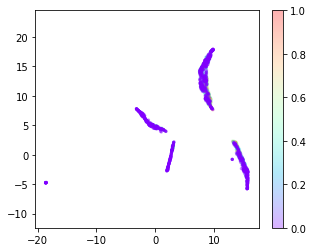

In [7]:
embedding = umap.UMAP(random_state=50).fit_transform(trainDataFormated)
displayResultUMAP(embedding)

Attempt with parametricUMAP

(64, 64, 3)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

c:\Users\junodch\.conda\envs\BT-Junodch\lib\site-packages\umap\parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(
c:\Users\junodch\.conda\envs\BT-Junodch\lib\site-packages\umap\parametric_umap.py:173: UserWarning: Parametric decoding is not implemented with nonparametric             embedding. Turning off parametric decoding
  warn(


Text(0.5, 0, 'Epoch')

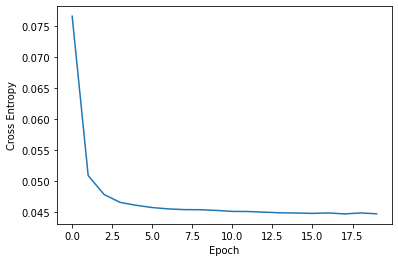

In [9]:
input_shape=train.shape[1:]
print(input_shape)

encoder = keras.Sequential([
  layers.Conv2D(12,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(12,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2D(12,(3,3), 2, padding='same', activation='relu'),

  layers.Flatten(),
  layers.Dense(units=2, name='encoder'),
])

decoder = keras.Sequential([
  layers.Dense(np.prod((8,8,12)), activation='relu', input_shape=(2,)),
  layers.Reshape(target_shape=(8,8,12)),
  layers.Conv2DTranspose(12,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(12,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(3, (3,3), 2, padding='same', activation='sigmoid'),
])

lossFunction = keras.losses.MeanSquaredError() # l2

embedder = ParametricUMAP(
  encoder=encoder,
  decoder=decoder,
  autoencoder_loss=True,
  parametric_reconstruction_loss_fcn=lossFunction,
  dims=input_shape,
  parametric_reconstruction=True,
  parametric_embedding=False,
  #n_training_epochs = 1,
  loss_report_frequency=20,
  keras_fit_kwargs={
    "callbacks": [TqdmCallback(verbose=1)],
    "verbose": 0,
  },
  verbose=False,
)

embedding = embedder.fit_transform(trainDataFormated)

fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')

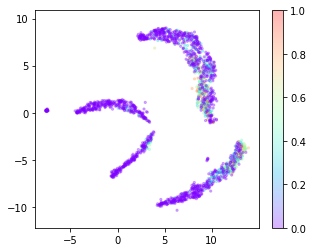

In [10]:
displayResultUMAP(embedding)

65/65 [==============================] - 0s 4ms/step


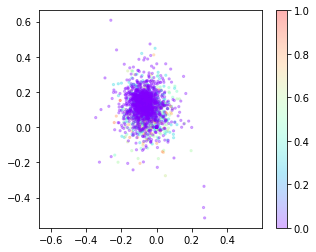

In [11]:
embedding = encoder.predict(train)
displayResultUMAP(embedding)

In [12]:
def displayAutoencoderUmapResults(autoencoder, dataInput, precision=0, isEmbedded=True):
  MAX_ON_ROW = 20
  total = dataInput.shape[0]
  nRow = (dataInput.shape[0] // MAX_ON_ROW) + 1
  nCol = MAX_ON_ROW if total > MAX_ON_ROW else total

  # Display original
  plt.figure(figsize=(30,nRow*2))
  for i in range(0, total):
    ax = plt.subplot(nRow, nCol, 1+i)
    plt.imshow(dataInput[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  print("Original data:",dataInput.shape)
  plt.show()

  # Display reconstruction
  if isEmbedded:
    decoded_imgs = autoencoder.inverse_transform(autoencoder.transform(dataInput))
  else:
    test = []
    for d in dataInput:
      test.append(tf.reshape(d, [-1]))
    decoded_imgs = autoencoder.inverse_transform(autoencoder.transform(test))
  plt.figure(figsize=(30,nRow*2))
  print("Output data:",decoded_imgs.shape)
  for i in range(0, decoded_imgs.shape[0]):
    ax = plt.subplot(nRow, nCol, 1+i)
    if isEmbedded:
      decoded_img = decoded_imgs[i]
    else:
      decoded_img = tf.reshape(decoded_imgs[i], [64,64,3])
    plt.imshow(decoded_img)
    score = lossFunction(dataInput[i], decoded_img)
    plt.title(np.round(score,precision))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Original data: (21, 64, 64, 3)


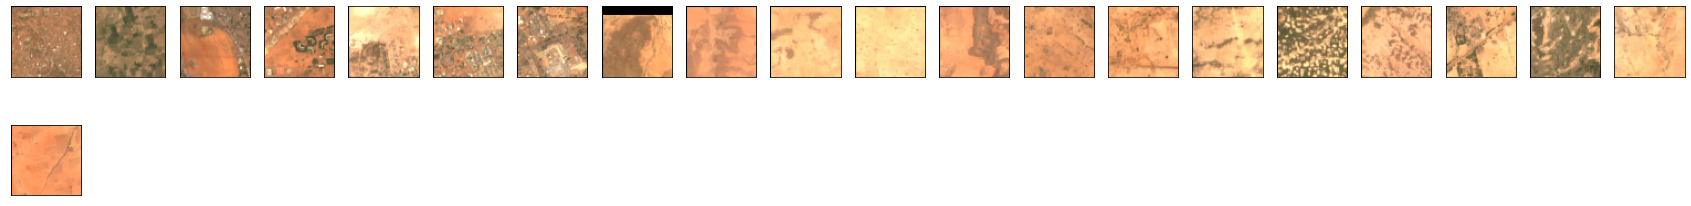

c:\Users\junodch\.conda\envs\BT-Junodch\lib\site-packages\umap\parametric_umap.py:236: UserWarning: Embedding new data is not supported by ParametricUMAP.                 Using original embedder.
  warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output data: (21, 12288)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


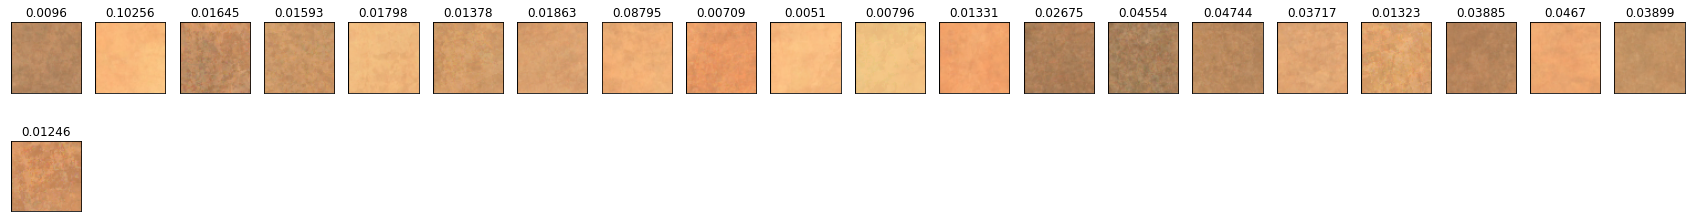

In [15]:
displayAutoencoderUmapResults(embedder, trainData[::100], precision=5, isEmbedded=False)